##Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##ResNet Implementation

### Load Dataset


torchvision 패키지에서 제공하는 STL-10

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data = '/data'

if  not os.path.exists(path2data):
  os.mkdir(path2data)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transformer)
valid_ds = datasets.STL10(path2data, split='test', download='True', transform=data_transformer)

print(train_ds.data.shape)
print(valid_ds.data.shape)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /data/stl10_binary.tar.gz to /data
Files already downloaded and verified
(5000, 3, 96, 96)
(8000, 3, 96, 96)


(3, 96, 96)


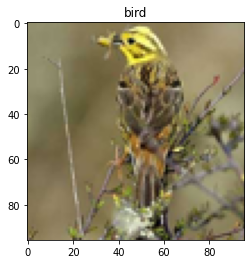

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample = train_ds.data[0]
print(sample.shape)
sample = np.transpose(sample, (1,2,0))
plt.title(train_ds.classes[train_ds.labels[0]])
plt.imshow(sample)

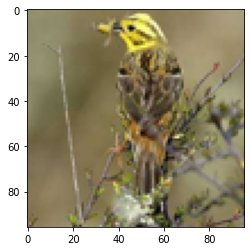

In [ ]:
# train_ds에서 뽑은 tensor 데이터와 train_ds.data에서 뽑은 numpy 데이터 차이

data_sample = train_ds.data[0]
# print(data_sample)

for x, _ in train_ds:
  dataset_sample = x
  break
dataset_sample = dataset_sample.numpy()
dataset_sample = np.transpose(dataset_sample, (1,2,0))
# print(dataset_sample)
plt.imshow(dataset_sample)

##Data normalization

In [ ]:
# normalize transformation을 적용하기 위해 평균, 표준편차 계산
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in valid_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in valid_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


In [ ]:
# transformation 객체 생성
from torch.utils.data import DataLoader

train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
])

# apply transforamtion
train_ds.transform = train_transformation
valid_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

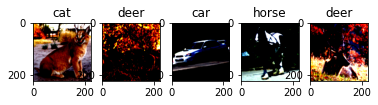

In [ ]:
# check dataloader
for i in range(5):
  plt.subplot(1,5, i + 1)
  img, l = next(iter(train_dl))
  dp_img = np.transpose(img[i], (1,2,0))
  plt.title(train_ds.classes[l[i]])
  plt.imshow(dp_img)

### implementation

In [9]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    self.residual_function = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False), # BatchNorm에 bias가 포함되어 있으므로 여기선 False
        nn.BatchNorm2d(out_channels), 
        nn.Relu(),
        nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels * BasicBlock.expansion)
    )

    self.shortcut = nn.Sequential()
    self.relu = nn.ReLu()

    # projection mapping using 1x1 conv
    if stride != 1 or in_channels != BasicBlock.expansion * out_channels: # stride가 1이 아니거나 입출력 채널이 서로 다를 때. stride 가 1이 아니면 왜?
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
          BatchNorm2d(out_channels * BasicBlock.expansion)
      )
    
    def forward(self, x):
      x = self.residual_function(x) + self.shortcut(x)
      x = self.relu(x)
      return (x)

In [10]:
class BottleNeck(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    expansion = 4
    super().__init__()

    self.residual_function = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLu(),
        nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
        nn.BatchNorm2d(out_channels * BottleNeck.expansion)
    )

    self.shortcut = nn.Sequential()
    self.relu = nn.ReLu()

    if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels * BottleNeck.expansion)
      )

      def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return (x)